In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad_vec
from mpl_toolkits.mplot3d import Axes3D

from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm

In [40]:

from astropy.cosmology import Planck18 as cosmo
from astropy import units as u

# Get the Hubble constant in the default units (km/s/Mpc)
H0 = cosmo.H0

# Convert 1/H0 to gigayears
H0_inverse = (1 / H0).to(u.Gyr)

print(f"1/H0 in gigayears: {H0_inverse:.3f}")

1/H0 in gigayears: 14.4515551534 Gyr


In [42]:
print(f'H0: {H0:.10f}')

H0: 67.6600000000 km / (Mpc s)


In [3]:
def integrand(a, omegam, omegalamb):
    omega0 = omegam + omegalamb
    y = (omegam/a+omegalamb*a**2+(1-omega0))**(-1/2)
    return y
def AgeofUniverse(ScaleFactor, omegam, omegalamb):
    I = quad_vec(integrand,0,ScaleFactor, args=(omegam, omegalamb))
    T = I[0]*H0_inverse # age is in Gyr, 1/H_0 ~ 14.452 Gyr
    return T


In [25]:
OmegamArr = np.arange(1,100)/100
OmegalambArr = np.arange(1,100)/100
FlatOmegalambArr = 1-OmegamArr
OmegamX, OmegalambY = np.meshgrid(OmegamArr, OmegalambArr)
#_, FlatOmegalambY = np.meshgrid(OmegamArr, FlatOmegalambArr)
AgeArr = AgeofUniverse(1, OmegamX, OmegalambY)
FlatAgeArr = AgeofUniverse(1, OmegamArr, FlatOmegalambArr)

# Ωm = 0.31에 가장 가까운 인덱스 찾기
idx_m = np.abs(OmegamArr - 0.31).argmin()
idx_l = np.abs(OmegalambArr - 0.69).argmin()
print(f"Ωm = 0.31, ΩΛ = 0.69일 때의 우주 나이: {AgeArr[idx_l,idx_m]:.3f} Gyr")

Ωm = 0.31, ΩΛ = 0.69일 때의 우주 나이: 13.805 Gyr Gyr


In [65]:
Omegamcur = cosmo.Om0
Omegalambcur = 1-Omegamcur
Agecur = AgeofUniverse(1, Omegamcur, Omegalambcur)

print(f"Omegamcur: {Omegamcur:.3f}")
print(f"Omegalambcur: {Omegalambcur:.3f}")
print(f"Age of Universe: {Agecur:.3f}")

Omegamcur: 0.310
Omegalambcur: 0.690
Age of Universe: 13.810 Gyr


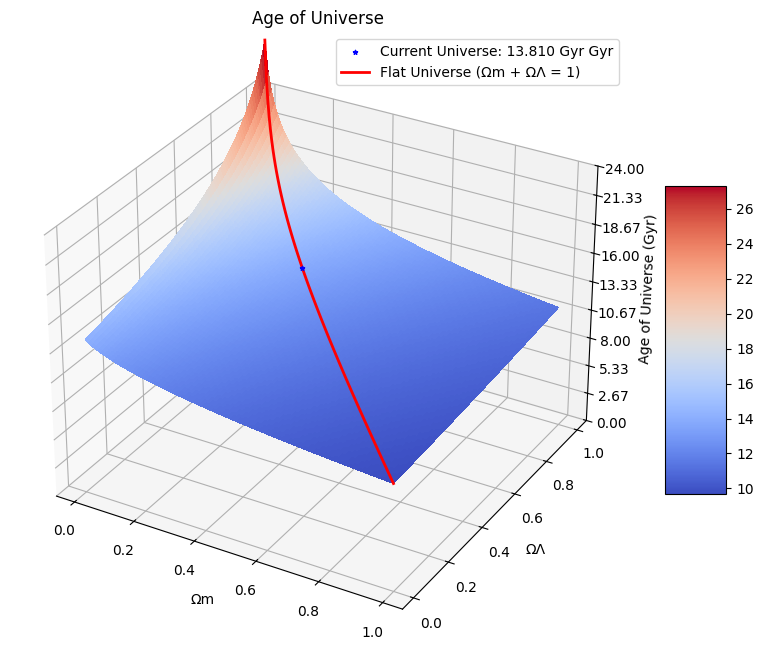

In [73]:
plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d',computed_zorder=False)
ax.scatter(Omegamcur, Omegalambcur, Agecur, c='blue', s=10, marker='*', label=f'Current Universe: {Agecur:.3f} Gyr',zorder=3, depthshade=False)
surf = ax.plot_surface(OmegamX, OmegalambY, AgeArr, 
                      rstride=1, cstride=1, 
                      cmap=cm.coolwarm, 
                      linewidth=0, 
                      antialiased=False, alpha=1)  # alpha 값을 더 낮춰서 투명도 증가
ax.plot3D(OmegamArr, FlatOmegalambArr, FlatAgeArr, 'red', linewidth=2, label='Flat Universe (Ωm + ΩΛ = 1)', zorder=2)


ax.set_xlabel('Ωm')
ax.set_ylabel('ΩΛ')
ax.set_zlabel('Age of Universe (Gyr)')
ax.set_zlim(0, 24)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

plt.legend()
plt.colorbar(surf, shrink=0.5, aspect=5)
plt.title('Age of Universe')
plt.show()

### Calculate Luminosity Distance

In [25]:

from astropy.constants import c
c_proper = c.to('Mpc/Gyr')

In [51]:
def E_inverse(z, omegam, omegalamb): # calculate E(z)
    omega0 = omegam + omegalamb
    y = (omegam*(1+z)**3+omegalamb+(1-omega0)*(1+z)**2)**(1/2)
    return 1/y
def R_k(omegam, omegalamb): # calculate curvature scale
     omega0 = omegam + omegalamb
     R_k = 1/np.sqrt(abs(1-omega0))
     return R_k
def Properdist(z, omegam, omegalamb): # return S_k(r) in Mpc
    omega0 = omegam + omegalamb
    result = np.zeros_like(omega0)
    
    # 1-omega0 == 0인 경우
    mask_flat = (1-omega0 == 0)
    result[mask_flat] = H0_inverse * c_proper * quad_vec(E_inverse, 0, z, args=(omegam[mask_flat], omegalamb[mask_flat]))[0]
    
    # 1-omega0 < 0인 경우 (closed universe)
    mask_closed = (1-omega0 < 0)
    R_k_closed = R_k(omegam[mask_closed], omegalamb[mask_closed])
    result[mask_closed] = R_k_closed * c_proper * H0_inverse * np.sin(1/R_k_closed * quad_vec(E_inverse, 0, z, args=(omegam[mask_closed], omegalamb[mask_closed]))[0])
    
    # 1-omega0 > 0인 경우 (open universe)
    mask_open = (1-omega0 > 0)
    R_k_open = R_k(omegam[mask_open], omegalamb[mask_open])
    result[mask_open] = R_k_open * c_proper * H0_inverse * np.sinh(1/R_k_open * quad_vec(E_inverse, 0, z, args=(omegam[mask_open], omegalamb[mask_open]))[0])
    
    return result

def Lumdist(z, properdist):
    return properdist * (1+z)




     

In [58]:

Omegamcur = cosmo.Om0
Omegalambcur = 1-Omegamcur
d = Properdist(0.1,np.array([Omegamcur]),np.array([Omegalambcur]))
Ld = Lumdist(0.1,d)
print(f'Luminosity Distance: {Ld[0]:.3f} Mpc')

Luminosity Distance: 475.876 Mpc


In [ ]:
OmegamArr = np.arange(1,100)/100
OmegalambArr = np.arange(1,100)/100

FlatOmegalambArr = 1-OmegamArr
OmegamX, OmegalambY = np.meshgrid(OmegamArr, OmegalambArr)

In [53]:
comovingdistarr = Properdist(0.1,OmegamX,OmegalambY)
lumdistarr = Lumdist(0.1,comovingdistarr)


array([[465.32107002, 465.19919868, 465.07745188, ..., 454.15766333,
        454.04675855, 453.93595835],
       [465.5232474 , 465.40116623, 465.27921001, ..., 454.34137895,
        454.23029826, 454.11932245],
       [465.72577673, 465.60348505, 465.48131873, ..., 454.52538907,
        454.41413194, 454.30298001],
       ...,
       [486.52065942, 486.37498227, 486.22947931, ..., 473.27818593,
        473.14761987, 473.01719574],
       [486.7628195 , 486.61684825, 486.47105186, ..., 473.49485536,
        473.3640501 , 473.23338726],
       [487.00547416, 486.85920769, 486.71311674, ..., 473.71192615,
        473.58088087, 473.44997849]])

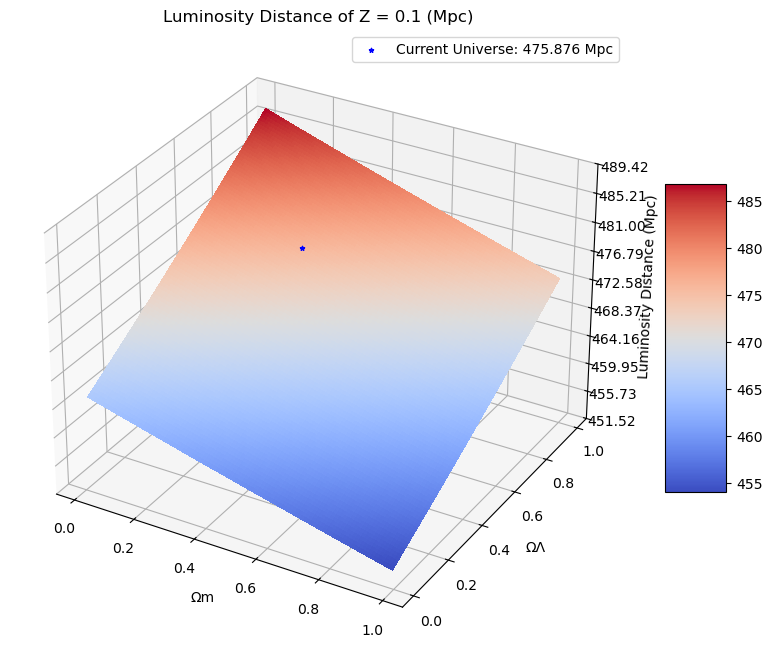

In [59]:
plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d',computed_zorder=False)
ax.scatter(Omegamcur, Omegalambcur, Ld, c='blue', s=10, marker='*', label=f'Current Universe: {Ld[0]:.3f} Mpc',zorder=3, depthshade=False)
surf = ax.plot_surface(OmegamX, OmegalambY, lumdistarr, 
                      rstride=1, cstride=1, 
                      cmap=cm.coolwarm, 
                      linewidth=0, 
                      antialiased=False, alpha=1)  # alpha 값을 더 낮춰서 투명도 증가
#ax.plot3D(OmegamArr, FlatOmegalambArr, FlatAgeArr, 'red', linewidth=2, label='Flat Universe (Ωm + ΩΛ = 1)', zorder=2)


ax.set_xlabel('Ωm')
ax.set_ylabel('ΩΛ')
ax.set_zlabel('Luminosity Distance (Mpc)')
#ax.set_zlim(0, 24)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

plt.legend()
plt.colorbar(surf, shrink=0.5, aspect=5)
plt.title('Luminosity Distance of Z = 0.1 (Mpc)')
plt.show()